In [1]:
# Cell 1: ÂØºÂÖ•‰æùËµñÂíåÁéØÂ¢ÉËÆæÁΩÆ
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# ËÆæÁΩÆÈöèÊú∫ÁßçÂ≠ê
torch.manual_seed(42)
np.random.seed(42)

print("üöÄ KaggleÂ§öÊ®°ÂûãÈõÜÊàêÊ∑±Â∫¶‰º™ÈÄ†Ê£ÄÊµã")
print(f"PyTorchÁâàÊú¨: {torch.__version__}")


üöÄ KaggleÂ§öÊ®°ÂûãÈõÜÊàêÊ∑±Â∫¶‰º™ÈÄ†Ê£ÄÊµã
PyTorchÁâàÊú¨: 2.6.0+cu124


In [2]:
# Cell 2: ÂèÇÊï∞ÈÖçÁΩÆ
# KaggleÁéØÂ¢ÉË∑ØÂæÑ
BASE_PATH = '/kaggle/input/deepfake-and-real-images/Dataset'
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
VAL_PATH = os.path.join(BASE_PATH, 'Validation')

# ËÆ≠ÁªÉÂèÇÊï∞
# ÂõæÂÉèÂ§ßÂ∞è
IMG_SIZE = 256

# ËÆ≠ÁªÉÊâπÊ¨°Â§ßÂ∞è
BATCH_SIZE = 32

# Â≠¶‰π†Áéá
LEARNING_RATE = 1e-4

# ËÆ≠ÁªÉËΩÆÊï∞
EPOCHS = 15

# ÊùÉÈáçË°∞ÂáèÁ≥ªÊï∞
WEIGHT_DECAY = 1e-4

# Êó©ÂÅúËΩÆÊï∞
PATIENCE = 3

# Â§öGPUËÆæÁΩÆ
NUM_GPUS = torch.cuda.device_count()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"‰ΩøÁî®ËÆæÂ§á: {DEVICE}")
if torch.cuda.is_available():
    if NUM_GPUS > 1:
        print(f"‰ΩøÁî®Â§öGPUËÆ≠ÁªÉ: {[torch.cuda.get_device_name(i) for i in range(NUM_GPUS)]}")
        print(f"GPUÊï∞Èáè: {NUM_GPUS}")
        NUM_WORKERS = 4  # Â§öGPUÊó∂Â¢ûÂä†Êï∞ÊçÆÂä†ËΩΩÁ∫øÁ®ã
    else:
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        NUM_WORKERS = 0  # ÂçïGPUÊó∂ÈÅøÂÖçÂ§öËøõÁ®ãÈóÆÈ¢ò
    
    for i in range(NUM_GPUS):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"GPU {i} ÂÜÖÂ≠ò: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f}GB")
else:
    NUM_WORKERS = 0
    print("‰ΩøÁî®CPUËÆ≠ÁªÉ")


‰ΩøÁî®ËÆæÂ§á: cuda
‰ΩøÁî®Â§öGPUËÆ≠ÁªÉ: ['Tesla T4', 'Tesla T4']
GPUÊï∞Èáè: 2
GPU 0: Tesla T4
GPU 0 ÂÜÖÂ≠ò: 14.7GB
GPU 1: Tesla T4
GPU 1 ÂÜÖÂ≠ò: 14.7GB


In [3]:
# Cell 3: Êï∞ÊçÆÂä†ËΩΩÂáΩÊï∞
classes = ['Real', 'Fake']

def create_dataframe(data_path, dataset_type):
    """ÂàõÂª∫Êï∞ÊçÆÈõÜDataFrame"""
    filepaths, labels = [], []
    
    for label_idx, cls in enumerate(classes):
        folder = os.path.join(data_path, cls)
        if os.path.exists(folder):
            for img_name in os.listdir(folder):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    filepaths.append(os.path.join(folder, img_name))
                    labels.append(label_idx)
    
    df = pd.DataFrame({'filepath': filepaths, 'label': labels})
    print(f"{dataset_type}ÈõÜÂõæÁâáÊï∞: {len(df)}")
    if len(df) > 0:
        print(f"{dataset_type}ÈõÜÁ±ªÂà´ÂàÜÂ∏É:")
        for idx, cls in enumerate(classes):
            count = len(df[df['label'] == idx])
            print(f"  {cls}: {count} ({count/len(df)*100:.1f}%)")
    return df

In [4]:
# Cell 4: Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜÂíåÂ¢ûÂº∫
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class DeepfakeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)
        
        label = self.df.iloc[idx]['label']
        return img, label

In [5]:
# Cell 5: Ê®°ÂûãÂÆö‰πâ
def create_efficientnet_b0():
    """ÂàõÂª∫EfficientNet-B0Ê®°Âûã"""
    model = models.efficientnet_b0(weights='IMAGENET1K_V1')
    model.classifier[1] = nn.Linear(1280, 2)
    return model

def create_resnet18():
    """ÂàõÂª∫ResNet18Ê®°Âûã"""
    model = models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(512, 2)
    return model

def create_convnext_tiny():
    """ÂàõÂª∫ConvNeXt-TinyÊ®°Âûã"""
    model = models.convnext_tiny(weights='IMAGENET1K_V1')
    model.classifier[2] = nn.Linear(768, 2)
    return model

# Ê®°ÂûãÈÖçÁΩÆÂ≠óÂÖ∏
MODEL_CONFIGS = {
    'efficientnet_b0': {
        'create_fn': create_efficientnet_b0,
        'name': 'EfficientNet-B0'
    },
    'resnet18': {
        'create_fn': create_resnet18,
        'name': 'ResNet18'
    },
    'convnext_tiny': {
        'create_fn': create_convnext_tiny,
        'name': 'ConvNeXt-Tiny'
    }
}

In [6]:
# Cell 6: ÂçïÊ®°ÂûãËÆ≠ÁªÉÂáΩÊï∞
def train_single_model(model_key, train_loader, val_loader, save_path):
    """ËÆ≠ÁªÉÂçï‰∏™Ê®°Âûã"""
    print(f"\nüî• ÂºÄÂßãËÆ≠ÁªÉ {MODEL_CONFIGS[model_key]['name']}")
    
    # ÂàõÂª∫Ê®°Âûã
    model = MODEL_CONFIGS[model_key]['create_fn']()
    model = model.to(DEVICE)
    
    # Â§öGPUÊîØÊåÅ
    if NUM_GPUS > 1:
        model = nn.DataParallel(model)
        print(f"‚úÖ Ê®°ÂûãÂ∑≤ÈÖçÁΩÆ‰∏∫Â§öGPUËÆ≠ÁªÉÔºå‰ΩøÁî® {NUM_GPUS} ‰∏™GPU")
    
    # ÊçüÂ§±ÂáΩÊï∞Âíå‰ºòÂåñÂô®
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # ËÆ≠ÁªÉËÆ∞ÂΩï
    best_val_acc = 0
    patience_counter = 0
    train_losses, val_losses, val_accuracies = [], [], []
    
    for epoch in range(EPOCHS):
        # ËÆ≠ÁªÉÈò∂ÊÆµ
        model.train()
        train_loss = 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # È™åËØÅÈò∂ÊÆµ
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {current_lr:.6f}")
        
        # ‰øùÂ≠òÊúÄ‰Ω≥Ê®°Âûã
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # ‰øùÂ≠òÊ®°ÂûãÊó∂Â§ÑÁêÜÂ§öGPUÊÉÖÂÜµ
            if NUM_GPUS > 1:
                torch.save(model.module.state_dict(), save_path)
            else:
                torch.save(model.state_dict(), save_path)
            print(f"‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("‚õî Early stopping triggered")
                break
    
    return best_val_acc, train_losses, val_losses, val_accuracies


In [7]:
# Cell 7: ÈõÜÊàêÈ¢ÑÊµãÂáΩÊï∞
def load_trained_models(model_paths):
    """Âä†ËΩΩËÆ≠ÁªÉÂ•ΩÁöÑÊ®°Âûã"""
    models_dict = {}
    for model_key, path in model_paths.items():
        if os.path.exists(path):
            model = MODEL_CONFIGS[model_key]['create_fn']()
            model.load_state_dict(torch.load(path, map_location=DEVICE))
            model = model.to(DEVICE)
            
            # Â§öGPUÊîØÊåÅ
            if NUM_GPUS > 1:
                model = nn.DataParallel(model)
                print(f"‚úÖ Â∑≤Âä†ËΩΩ {MODEL_CONFIGS[model_key]['name']} (Â§öGPUÊ®°Âºè)")
            else:
                print(f"‚úÖ Â∑≤Âä†ËΩΩ {MODEL_CONFIGS[model_key]['name']}")
            
            model.eval()
            models_dict[model_key] = model
        else:
            print(f"‚ùå Ê®°ÂûãÊñá‰ª∂‰∏çÂ≠òÂú®: {path}")
    return models_dict

def ensemble_predict(models_dict, data_loader, voting_type='soft', weights=None):
    """ÈõÜÊàêÈ¢ÑÊµã"""
    all_predictions = []
    all_labels = []
    model_outputs = {key: [] for key in models_dict.keys()}
    
    # Â¶ÇÊûúÊòØÂä†ÊùÉÊäïÁ•®‰ΩÜÊ≤°ÊúâÊèê‰æõÊùÉÈáçÔºåÂàô‰ΩøÁî®Á≠âÊùÉÈáç
    if voting_type == 'weighted' and weights is None:
        weights = {key: 1.0 for key in models_dict.keys()}
    
    with torch.no_grad():
        for imgs, labels in tqdm(data_loader, desc="ÈõÜÊàêÈ¢ÑÊµã"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            
            # Êî∂ÈõÜÊØè‰∏™Ê®°ÂûãÁöÑÈ¢ÑÊµã
            batch_predictions = []
            for model_key, model in models_dict.items():
                outputs = model(imgs)
                if voting_type in ['soft', 'weighted']:
                    probs = torch.softmax(outputs, dim=1)
                    batch_predictions.append(probs.cpu().numpy())
                else:  # hard voting
                    _, predicted = torch.max(outputs, 1)
                    batch_predictions.append(predicted.cpu().numpy())
                
                model_outputs[model_key].extend(outputs.cpu().numpy())
            
            # ÈõÜÊàêÈ¢ÑÊµã
            if voting_type == 'soft':
                # ËΩØÊäïÁ•®ÔºöÂπ≥ÂùáÊ¶ÇÁéá
                ensemble_probs = np.mean(batch_predictions, axis=0)
                ensemble_pred = np.argmax(ensemble_probs, axis=1)
            elif voting_type == 'weighted':
                # Âä†ÊùÉÊäïÁ•®ÔºöÊ†πÊçÆÊùÉÈáçÂä†ÊùÉÂπ≥ÂùáÊ¶ÇÁéá
                weighted_probs = np.zeros_like(batch_predictions[0])
                total_weight = 0
                for i, (model_key, probs) in enumerate(zip(models_dict.keys(), batch_predictions)):
                    weight = weights[model_key]
                    weighted_probs += probs * weight
                    total_weight += weight
                ensemble_probs = weighted_probs / total_weight
                ensemble_pred = np.argmax(ensemble_probs, axis=1)
            else:
                # Á°¨ÊäïÁ•®ÔºöÂ§öÊï∞ÊäïÁ•®
                batch_predictions = np.array(batch_predictions)
                ensemble_pred = []
                for i in range(batch_predictions.shape[1]):
                    votes = batch_predictions[:, i]
                    ensemble_pred.append(np.bincount(votes).argmax())
                ensemble_pred = np.array(ensemble_pred)
            
            all_predictions.extend(ensemble_pred)
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), model_outputs

def calculate_model_weights(model_results, weight_method='accuracy'):
    """ËÆ°ÁÆóÊ®°ÂûãÊùÉÈáç"""
    weights = {}
    
    if weight_method == 'accuracy':
        # Âü∫‰∫éÈ™åËØÅÂáÜÁ°ÆÁéáËÆ°ÁÆóÊùÉÈáç
        accuracies = {key: results['best_acc'] for key, results in model_results.items()}
        total_acc = sum(accuracies.values())
        
        for key, acc in accuracies.items():
            weights[key] = acc / total_acc
            
    elif weight_method == 'softmax':
        # ‰ΩøÁî®softmaxÂΩí‰∏ÄÂåñÂáÜÁ°ÆÁéá‰Ωú‰∏∫ÊùÉÈáç
        accuracies = np.array([results['best_acc'] for results in model_results.values()])
        softmax_weights = np.exp(accuracies * 10) / np.sum(np.exp(accuracies * 10))  # ‰πò‰ª•10Â¢ûÂº∫Â∑ÆÂºÇ
        
        for i, key in enumerate(model_results.keys()):
            weights[key] = softmax_weights[i]
            
    elif weight_method == 'rank':
        # Âü∫‰∫éÊéíÂêçÁöÑÊùÉÈáçÂàÜÈÖç
        sorted_models = sorted(model_results.items(), key=lambda x: x[1]['best_acc'], reverse=True)
        n_models = len(sorted_models)
        
        for i, (key, _) in enumerate(sorted_models):
            weights[key] = (n_models - i) / sum(range(1, n_models + 1))
    
    return weights

In [8]:
# Cell 8: Âä†ËΩΩÊï∞ÊçÆ
print("üìÇ Âä†ËΩΩÊï∞ÊçÆÈõÜ...")
train_df = create_dataframe(TRAIN_PATH, "ËÆ≠ÁªÉ")
val_df = create_dataframe(VAL_PATH, "È™åËØÅ")

# ÈôêÂà∂È™åËØÅÈõÜÂ§ßÂ∞è‰∏∫6400‰ª•ÂáèÂ∞ëÂÜÖÂ≠ò‰ΩøÁî®
MAX_VAL_SAMPLES = 6400
if len(val_df) > MAX_VAL_SAMPLES:
    print(f"‚ö†Ô∏è È™åËØÅÈõÜËøáÂ§ß ({len(val_df)} Âº†)ÔºåÈöèÊú∫ÈááÊ†∑ {MAX_VAL_SAMPLES} Âº†ÂõæÁâá")
    # ‰øùÊåÅÁ±ªÂà´Âπ≥Ë°°ÁöÑÈöèÊú∫ÈááÊ†∑
    val_df = val_df.groupby('label', group_keys=False).apply(
        lambda x: x.sample(min(len(x), MAX_VAL_SAMPLES//2), random_state=42)
    ).reset_index(drop=True)
    print(f"‚úÖ È™åËØÅÈõÜÈááÊ†∑ÂÆåÊàêÔºåÂΩìÂâçÂ§ßÂ∞è: {len(val_df)}")
    print(f"È™åËØÅÈõÜÁ±ªÂà´ÂàÜÂ∏É:")
    for idx, cls in enumerate(classes):
        count = len(val_df[val_df['label'] == idx])
        print(f"  {cls}: {count} ({count/len(val_df)*100:.1f}%)")

print(f"\nüìä Êï∞ÊçÆÈõÜÊÄªËßà:")
print(f"ËÆ≠ÁªÉÈõÜÊÄªÊï∞: {len(train_df)}")
print(f"È™åËØÅÈõÜÊÄªÊï∞: {len(val_df)}")
print(f"È™åËØÅÊâπÊ¨°Êï∞: {len(val_df) // BATCH_SIZE + (1 if len(val_df) % BATCH_SIZE > 0 else 0)}")

# ÂàõÂª∫Êï∞ÊçÆÈõÜÂíåÊï∞ÊçÆÂä†ËΩΩÂô®
train_dataset = DeepfakeDataset(train_df, transform=train_transform)
val_dataset = DeepfakeDataset(val_df, transform=val_transform)

# ‰ΩøÁî®Âä®ÊÄÅÈÖçÁΩÆÁöÑnum_workersÂíåpin_memory
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


üìÇ Âä†ËΩΩÊï∞ÊçÆÈõÜ...
ËÆ≠ÁªÉÈõÜÂõæÁâáÊï∞: 140002
ËÆ≠ÁªÉÈõÜÁ±ªÂà´ÂàÜÂ∏É:
  Real: 70001 (50.0%)
  Fake: 70001 (50.0%)
È™åËØÅÈõÜÂõæÁâáÊï∞: 39428
È™åËØÅÈõÜÁ±ªÂà´ÂàÜÂ∏É:
  Real: 19787 (50.2%)
  Fake: 19641 (49.8%)
‚ö†Ô∏è È™åËØÅÈõÜËøáÂ§ß (39428 Âº†)ÔºåÈöèÊú∫ÈááÊ†∑ 6400 Âº†ÂõæÁâá
‚úÖ È™åËØÅÈõÜÈááÊ†∑ÂÆåÊàêÔºåÂΩìÂâçÂ§ßÂ∞è: 6400
È™åËØÅÈõÜÁ±ªÂà´ÂàÜÂ∏É:
  Real: 3200 (50.0%)
  Fake: 3200 (50.0%)

üìä Êï∞ÊçÆÈõÜÊÄªËßà:
ËÆ≠ÁªÉÈõÜÊÄªÊï∞: 140002
È™åËØÅÈõÜÊÄªÊï∞: 6400
È™åËØÅÊâπÊ¨°Êï∞: 200


In [9]:
# Cell 9: ËÆ≠ÁªÉÊâÄÊúâÊ®°Âûã
print("\nüöÄ ÂºÄÂßãËÆ≠ÁªÉÂ§ö‰∏™Ê®°Âûã...")

# ÈÄâÊã©Ë¶ÅËÆ≠ÁªÉÁöÑÊ®°ÂûãÔºàÂèØ‰ª•Ê†πÊçÆÈúÄË¶ÅË∞ÉÊï¥Ôºâ
selected_models = ['efficientnet_b0', 'resnet18', 'convnext_tiny']  # ÂáèÂ∞ëÊ®°ÂûãÊï∞Èáè‰ª•ÈÄÇÂ∫îKaggleÁéØÂ¢É
model_paths = {}
model_results = {}

for model_key in selected_models:
    save_path = f"best_{model_key}_model.pth"
    model_paths[model_key] = save_path
    
    best_acc, train_losses, val_losses, val_accs = train_single_model(
        model_key, train_loader, val_loader, save_path
    )
    
    model_results[model_key] = {
        'best_acc': best_acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accs
    }
    
    print(f"‚úÖ {MODEL_CONFIGS[model_key]['name']} ËÆ≠ÁªÉÂÆåÊàêÔºåÊúÄ‰Ω≥È™åËØÅÂáÜÁ°ÆÁéá: {best_acc:.4f}")



üöÄ ÂºÄÂßãËÆ≠ÁªÉÂ§ö‰∏™Ê®°Âûã...

üî• ÂºÄÂßãËÆ≠ÁªÉ EfficientNet-B0


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20.5M/20.5M [00:00<00:00, 147MB/s]


‚úÖ Ê®°ÂûãÂ∑≤ÈÖçÁΩÆ‰∏∫Â§öGPUËÆ≠ÁªÉÔºå‰ΩøÁî® 2 ‰∏™GPU


Epoch 1/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0853, Val Loss: 0.0597, Val Acc: 0.9761, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9761


Epoch 2/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0446, Val Loss: 0.0583, Val Acc: 0.9758, LR: 0.000100


Epoch 3/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0374, Val Loss: 0.0612, Val Acc: 0.9795, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9795


Epoch 4/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0350, Val Loss: 0.0468, Val Acc: 0.9830, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9830


Epoch 5/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0318, Val Loss: 0.0551, Val Acc: 0.9794, LR: 0.000100


Epoch 6/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0317, Val Loss: 0.0547, Val Acc: 0.9800, LR: 0.000100


Epoch 7/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0307, Val Loss: 0.0422, Val Acc: 0.9845, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9845


Epoch 8/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0294, Val Loss: 0.0447, Val Acc: 0.9844, LR: 0.000100


Epoch 9/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0294, Val Loss: 0.1091, Val Acc: 0.9642, LR: 0.000100


Epoch 10/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0289, Val Loss: 0.0579, Val Acc: 0.9791, LR: 0.000100
‚õî Early stopping triggered
‚úÖ EfficientNet-B0 ËÆ≠ÁªÉÂÆåÊàêÔºåÊúÄ‰Ω≥È™åËØÅÂáÜÁ°ÆÁéá: 0.9845

üî• ÂºÄÂßãËÆ≠ÁªÉ ResNet18


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 44.7M/44.7M [00:00<00:00, 155MB/s]

‚úÖ Ê®°ÂûãÂ∑≤ÈÖçÁΩÆ‰∏∫Â§öGPUËÆ≠ÁªÉÔºå‰ΩøÁî® 2 ‰∏™GPU


Epoch 1/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0840, Val Loss: 0.0761, Val Acc: 0.9669, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9669


Epoch 2/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0509, Val Loss: 0.0720, Val Acc: 0.9728, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9728


Epoch 3/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0449, Val Loss: 0.0637, Val Acc: 0.9769, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9769


Epoch 4/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0415, Val Loss: 0.0960, Val Acc: 0.9688, LR: 0.000100


Epoch 5/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0383, Val Loss: 0.0516, Val Acc: 0.9814, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9814


Epoch 6/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0361, Val Loss: 0.0518, Val Acc: 0.9783, LR: 0.000100


Epoch 7/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0351, Val Loss: 0.0473, Val Acc: 0.9819, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9819


Epoch 8/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0335, Val Loss: 0.0584, Val Acc: 0.9764, LR: 0.000100


Epoch 9/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0329, Val Loss: 0.0671, Val Acc: 0.9758, LR: 0.000100


Epoch 10/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0318, Val Loss: 0.0586, Val Acc: 0.9780, LR: 0.000100
‚õî Early stopping triggered
‚úÖ ResNet18 ËÆ≠ÁªÉÂÆåÊàêÔºåÊúÄ‰Ω≥È™åËØÅÂáÜÁ°ÆÁéá: 0.9819

üî• ÂºÄÂßãËÆ≠ÁªÉ ConvNeXt-Tiny


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 109M/109M [00:00<00:00, 214MB/s]


‚úÖ Ê®°ÂûãÂ∑≤ÈÖçÁΩÆ‰∏∫Â§öGPUËÆ≠ÁªÉÔºå‰ΩøÁî® 2 ‰∏™GPU


Epoch 1/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.0678, Val Loss: 0.0885, Val Acc: 0.9652, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9652


Epoch 2/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0461, Val Loss: 0.0643, Val Acc: 0.9766, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9766


Epoch 3/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0434, Val Loss: 0.1061, Val Acc: 0.9609, LR: 0.000100


Epoch 4/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0409, Val Loss: 0.0547, Val Acc: 0.9778, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9778


Epoch 5/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0391, Val Loss: 0.0538, Val Acc: 0.9781, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9781


Epoch 6/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0370, Val Loss: 0.1013, Val Acc: 0.9705, LR: 0.000100


Epoch 7/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0361, Val Loss: 0.0478, Val Acc: 0.9808, LR: 0.000100
‚úÖ ÊúÄ‰Ω≥Ê®°ÂûãÂ∑≤‰øùÂ≠òÔºåÈ™åËØÅÂáÜÁ°ÆÁéá: 0.9808


Epoch 8/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0347, Val Loss: 0.0642, Val Acc: 0.9784, LR: 0.000100


Epoch 9/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0334, Val Loss: 0.0535, Val Acc: 0.9806, LR: 0.000100


Epoch 10/15 [Train]:   0%|          | 0/4376 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0333, Val Loss: 0.0913, Val Acc: 0.9680, LR: 0.000100
‚õî Early stopping triggered
‚úÖ ConvNeXt-Tiny ËÆ≠ÁªÉÂÆåÊàêÔºåÊúÄ‰Ω≥È™åËØÅÂáÜÁ°ÆÁéá: 0.9808


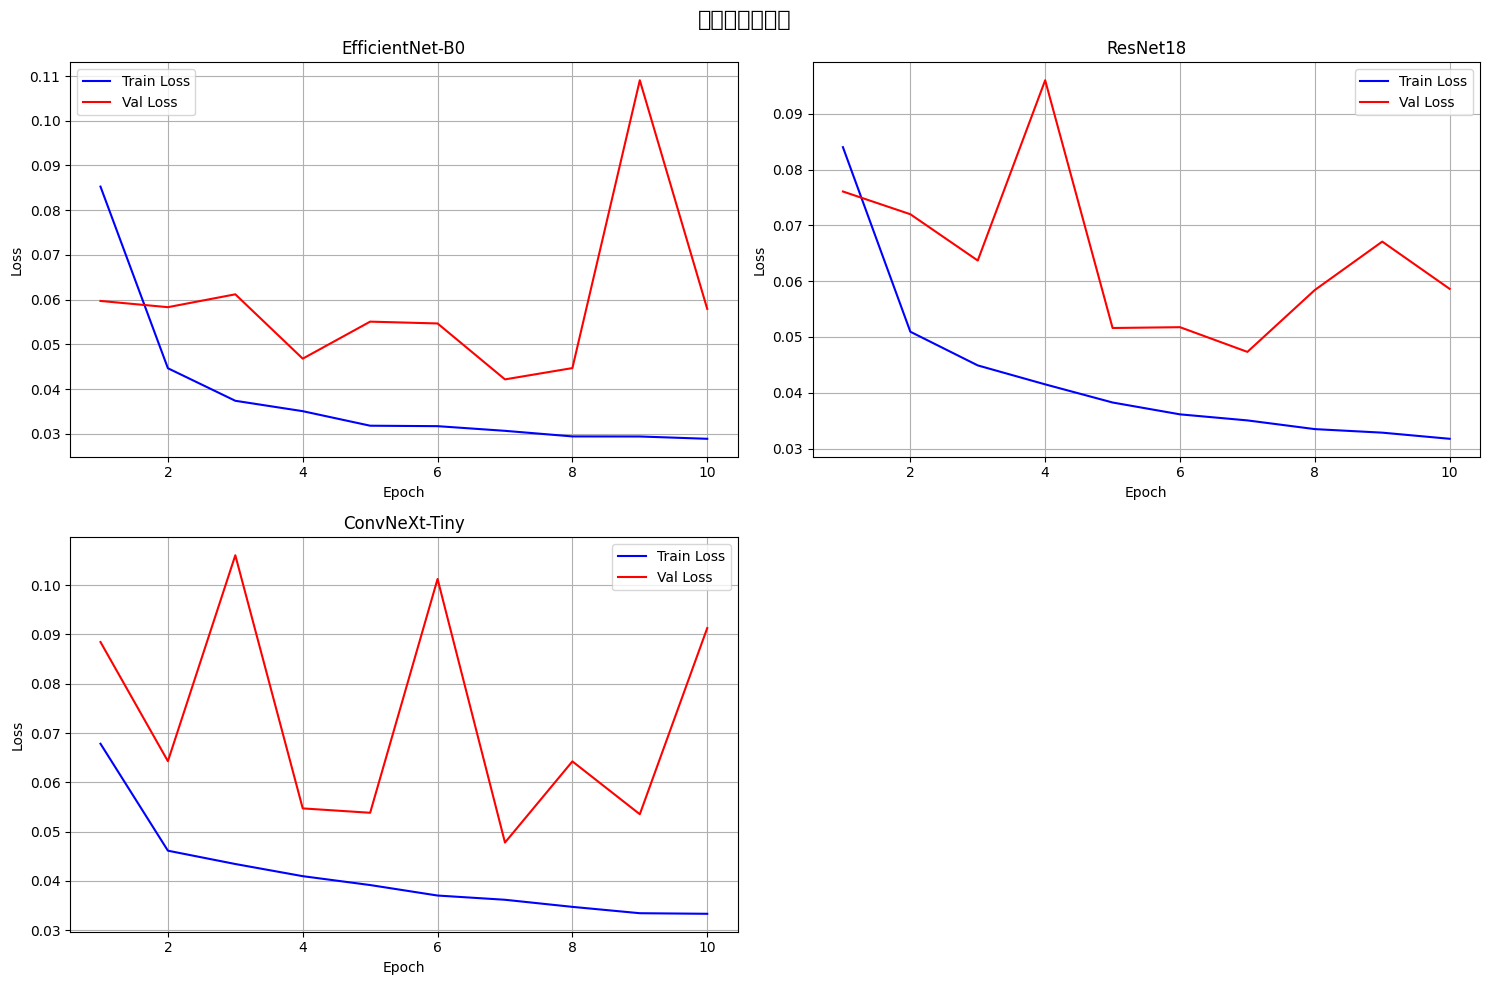

In [10]:
# Cell 10: ÂèØËßÜÂåñËÆ≠ÁªÉËøáÁ®ã
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Â§öÊ®°ÂûãËÆ≠ÁªÉËøáÁ®ã', fontsize=16)

for idx, (model_key, results) in enumerate(model_results.items()):
    row = idx // 2
    col = idx % 2
    
    ax = axes[row, col]
    epochs = range(1, len(results['train_losses']) + 1)
    
    ax.plot(epochs, results['train_losses'], 'b-', label='Train Loss')
    ax.plot(epochs, results['val_losses'], 'r-', label='Val Loss')
    ax.set_title(f"{MODEL_CONFIGS[model_key]['name']}")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

# Â¶ÇÊûúÊ®°ÂûãÊï∞ÈáèÂ∞ë‰∫é4‰∏™ÔºåÈöêËóèÂ§ö‰ΩôÁöÑÂ≠êÂõæ
for idx in range(len(model_results), 4):
    row = idx // 2
    col = idx % 2
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()


In [11]:
# Cell 11: ÈõÜÊàêÈ¢ÑÊµãÂíåËØÑ‰º∞
print("\nüîÆ ÂºÄÂßãÈõÜÊàêÈ¢ÑÊµã...")

# Âä†ËΩΩËÆ≠ÁªÉÂ•ΩÁöÑÊ®°Âûã
trained_models = load_trained_models(model_paths)

# ËÆ°ÁÆóÊ®°ÂûãÊùÉÈáç
print("\n‚öñÔ∏è ËÆ°ÁÆóÊ®°ÂûãÊùÉÈáç...")
model_weights = calculate_model_weights(model_results, weight_method='accuracy')
print("Ê®°ÂûãÊùÉÈáçÂàÜÈÖç:")
for model_key, weight in model_weights.items():
    print(f"  {MODEL_CONFIGS[model_key]['name']:15}: {weight:.4f}")

# ËΩØÊäïÁ•®È¢ÑÊµã
print("\nüìä ËΩØÊäïÁ•®ÈõÜÊàêÈ¢ÑÊµã:")
soft_predictions, true_labels, _ = ensemble_predict(trained_models, val_loader, voting_type='soft')
soft_accuracy = accuracy_score(true_labels, soft_predictions)
print(f"ËΩØÊäïÁ•®ÂáÜÁ°ÆÁéá: {soft_accuracy:.4f}")

# Á°¨ÊäïÁ•®È¢ÑÊµã
print("\nüìä Á°¨ÊäïÁ•®ÈõÜÊàêÈ¢ÑÊµã:")
hard_predictions, _, _ = ensemble_predict(trained_models, val_loader, voting_type='hard')
hard_accuracy = accuracy_score(true_labels, hard_predictions)
print(f"Á°¨ÊäïÁ•®ÂáÜÁ°ÆÁéá: {hard_accuracy:.4f}")

# Âä†ÊùÉÊäïÁ•®È¢ÑÊµã
print("\nüìä Âä†ÊùÉÊäïÁ•®ÈõÜÊàêÈ¢ÑÊµã:")
weighted_predictions, _, _ = ensemble_predict(trained_models, val_loader, voting_type='weighted', weights=model_weights)
weighted_accuracy = accuracy_score(true_labels, weighted_predictions)
print(f"Âä†ÊùÉÊäïÁ•®ÂáÜÁ°ÆÁéá: {weighted_accuracy:.4f}")



üîÆ ÂºÄÂßãÈõÜÊàêÈ¢ÑÊµã...
‚úÖ Â∑≤Âä†ËΩΩ EfficientNet-B0 (Â§öGPUÊ®°Âºè)
‚úÖ Â∑≤Âä†ËΩΩ ResNet18 (Â§öGPUÊ®°Âºè)
‚úÖ Â∑≤Âä†ËΩΩ ConvNeXt-Tiny (Â§öGPUÊ®°Âºè)

‚öñÔ∏è ËÆ°ÁÆóÊ®°ÂûãÊùÉÈáç...
Ê®°ÂûãÊùÉÈáçÂàÜÈÖç:
  EfficientNet-B0: 0.3341
  ResNet18       : 0.3332
  ConvNeXt-Tiny  : 0.3328

üìä ËΩØÊäïÁ•®ÈõÜÊàêÈ¢ÑÊµã:


ÈõÜÊàêÈ¢ÑÊµã:   0%|          | 0/200 [00:00<?, ?it/s]

ËΩØÊäïÁ•®ÂáÜÁ°ÆÁéá: 0.9869

üìä Á°¨ÊäïÁ•®ÈõÜÊàêÈ¢ÑÊµã:


ÈõÜÊàêÈ¢ÑÊµã:   0%|          | 0/200 [00:00<?, ?it/s]

Á°¨ÊäïÁ•®ÂáÜÁ°ÆÁéá: 0.9872

üìä Âä†ÊùÉÊäïÁ•®ÈõÜÊàêÈ¢ÑÊµã:


ÈõÜÊàêÈ¢ÑÊµã:   0%|          | 0/200 [00:00<?, ?it/s]

Âä†ÊùÉÊäïÁ•®ÂáÜÁ°ÆÁéá: 0.9869



üìà Ê®°ÂûãÊÄßËÉΩÂØπÊØî:
EfficientNet-B0: 0.9845
ResNet18       : 0.9819
ConvNeXt-Tiny  : 0.9808
ËΩØÊäïÁ•®ÈõÜÊàê          : 0.9869
Á°¨ÊäïÁ•®ÈõÜÊàê          : 0.9872
Âä†ÊùÉÊäïÁ•®ÈõÜÊàê         : 0.9869


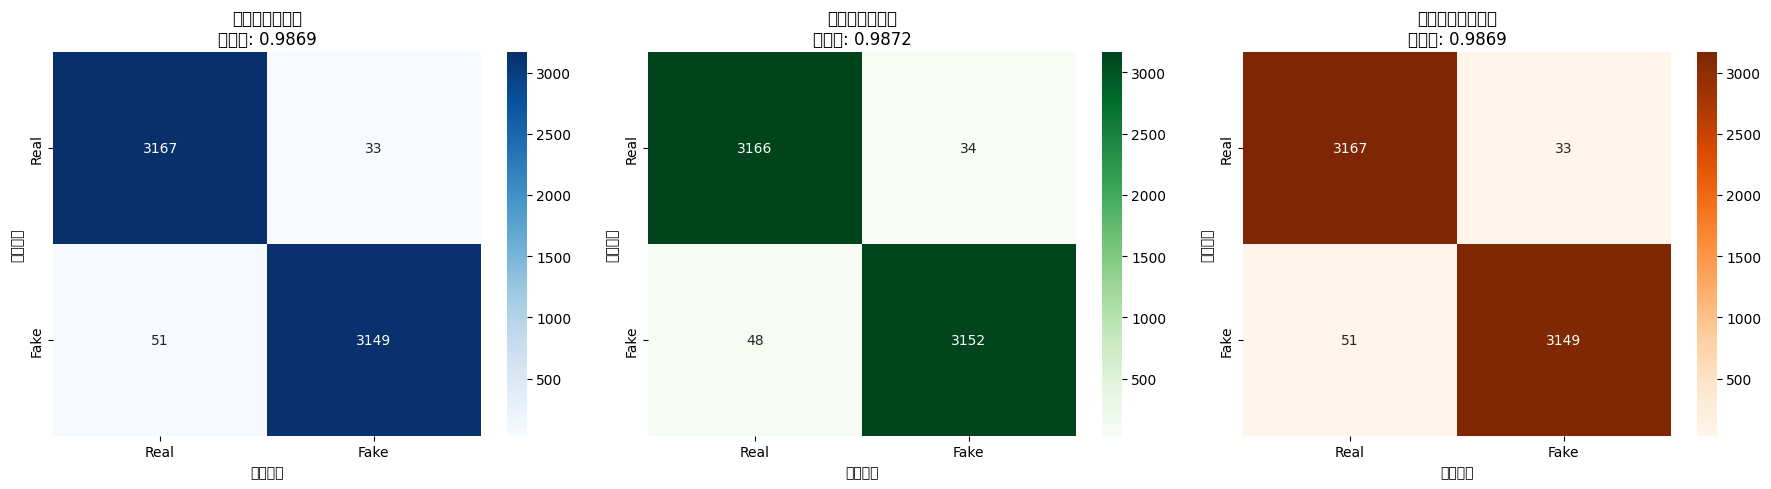

In [12]:
# Cell 12: ÁªìÊûúÂØπÊØîÂíåÂèØËßÜÂåñ
# ÂçïÊ®°ÂûãÁªìÊûúÂØπÊØî
print("\nüìà Ê®°ÂûãÊÄßËÉΩÂØπÊØî:")
print("="*50)
for model_key in selected_models:
    best_acc = model_results[model_key]['best_acc']
    print(f"{MODEL_CONFIGS[model_key]['name']:15}: {best_acc:.4f}")

print(f"{'ËΩØÊäïÁ•®ÈõÜÊàê':15}: {soft_accuracy:.4f}")
print(f"{'Á°¨ÊäïÁ•®ÈõÜÊàê':15}: {hard_accuracy:.4f}")
print(f"{'Âä†ÊùÉÊäïÁ•®ÈõÜÊàê':15}: {weighted_accuracy:.4f}")

# Ê∑∑Ê∑ÜÁü©ÈòµÂèØËßÜÂåñ
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ËΩØÊäïÁ•®Ê∑∑Ê∑ÜÁü©Èòµ
cm_soft = confusion_matrix(true_labels, soft_predictions)
sns.heatmap(cm_soft, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes, ax=axes[0])
axes[0].set_title(f"ËΩØÊäïÁ•®Ê∑∑Ê∑ÜÁü©Èòµ\nÂáÜÁ°ÆÁéá: {soft_accuracy:.4f}")
axes[0].set_ylabel("ÁúüÂÆûÊ†áÁ≠æ")
axes[0].set_xlabel("È¢ÑÊµãÊ†áÁ≠æ")

# Á°¨ÊäïÁ•®Ê∑∑Ê∑ÜÁü©Èòµ
cm_hard = confusion_matrix(true_labels, hard_predictions)
sns.heatmap(cm_hard, annot=True, fmt="d", cmap="Greens", 
            xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title(f"Á°¨ÊäïÁ•®Ê∑∑Ê∑ÜÁü©Èòµ\nÂáÜÁ°ÆÁéá: {hard_accuracy:.4f}")
axes[1].set_ylabel("ÁúüÂÆûÊ†áÁ≠æ")
axes[1].set_xlabel("È¢ÑÊµãÊ†áÁ≠æ")

# Âä†ÊùÉÊäïÁ•®Ê∑∑Ê∑ÜÁü©Èòµ
cm_weighted = confusion_matrix(true_labels, weighted_predictions)
sns.heatmap(cm_weighted, annot=True, fmt="d", cmap="Oranges", 
            xticklabels=classes, yticklabels=classes, ax=axes[2])
axes[2].set_title(f"Âä†ÊùÉÊäïÁ•®Ê∑∑Ê∑ÜÁü©Èòµ\nÂáÜÁ°ÆÁéá: {weighted_accuracy:.4f}")
axes[2].set_ylabel("ÁúüÂÆûÊ†áÁ≠æ")
axes[2].set_xlabel("È¢ÑÊµãÊ†áÁ≠æ")

plt.tight_layout()
plt.show()

In [13]:
# Cell 13: ËØ¶ÁªÜÂàÜÁ±ªÊä•Âëä
print("\nüìã ËΩØÊäïÁ•®ËØ¶ÁªÜÂàÜÁ±ªÊä•Âëä:")
print("="*50)
print(classification_report(true_labels, soft_predictions, target_names=classes))

print("\nüìã Á°¨ÊäïÁ•®ËØ¶ÁªÜÂàÜÁ±ªÊä•Âëä:")
print("="*50)
print(classification_report(true_labels, hard_predictions, target_names=classes))

print("\nüìã Âä†ÊùÉÊäïÁ•®ËØ¶ÁªÜÂàÜÁ±ªÊä•Âëä:")
print("="*50)
print(classification_report(true_labels, weighted_predictions, target_names=classes))



üìã ËΩØÊäïÁ•®ËØ¶ÁªÜÂàÜÁ±ªÊä•Âëä:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      3200
        Fake       0.99      0.98      0.99      3200

    accuracy                           0.99      6400
   macro avg       0.99      0.99      0.99      6400
weighted avg       0.99      0.99      0.99      6400


üìã Á°¨ÊäïÁ•®ËØ¶ÁªÜÂàÜÁ±ªÊä•Âëä:
              precision    recall  f1-score   support

        Real       0.99      0.99      0.99      3200
        Fake       0.99      0.98      0.99      3200

    accuracy                           0.99      6400
   macro avg       0.99      0.99      0.99      6400
weighted avg       0.99      0.99      0.99      6400


üìã Âä†ÊùÉÊäïÁ•®ËØ¶ÁªÜÂàÜÁ±ªÊä•Âëä:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      3200
        Fake       0.99      0.98      0.99      3200

    accuracy                           0.99      6400
   macro avg       0

In [14]:
# Cell 14: ÊúÄÁªàÊÄªÁªì
print("\n" + "="*60)
print("üéâ Â§öÊ®°ÂûãÈõÜÊàêËÆ≠ÁªÉÂÆåÊàêÔºÅ")
print("="*60)
print(f"ËÆ≠ÁªÉÁöÑÊ®°ÂûãÊï∞Èáè: {len(selected_models)}")
print(f"ÊúÄ‰Ω≥ÂçïÊ®°ÂûãÂáÜÁ°ÆÁéá: {max([results['best_acc'] for results in model_results.values()]):.4f}")
print(f"ËΩØÊäïÁ•®ÈõÜÊàêÂáÜÁ°ÆÁéá: {soft_accuracy:.4f}")
print(f"Á°¨ÊäïÁ•®ÈõÜÊàêÂáÜÁ°ÆÁéá: {hard_accuracy:.4f}")
print(f"Âä†ÊùÉÊäïÁ•®ÈõÜÊàêÂáÜÁ°ÆÁéá: {weighted_accuracy:.4f}")

# ËÆ°ÁÆóÊèêÂçáÂπÖÂ∫¶
best_single = max([results['best_acc'] for results in model_results.values()])
soft_improvement = (soft_accuracy - best_single) * 100
hard_improvement = (hard_accuracy - best_single) * 100
weighted_improvement = (weighted_accuracy - best_single) * 100

print(f"ËΩØÊäïÁ•®Áõ∏ÂØπÊèêÂçá: {soft_improvement:+.2f}%")
print(f"Á°¨ÊäïÁ•®Áõ∏ÂØπÊèêÂçá: {hard_improvement:+.2f}%")
print(f"Âä†ÊùÉÊäïÁ•®Áõ∏ÂØπÊèêÂçá: {weighted_improvement:+.2f}%")

# ÊâæÂá∫ÊúÄ‰Ω≥ÈõÜÊàêÊñπÊ≥ï
ensemble_results = {
    'ËΩØÊäïÁ•®': soft_accuracy,
    'Á°¨ÊäïÁ•®': hard_accuracy,
    'Âä†ÊùÉÊäïÁ•®': weighted_accuracy
}
best_ensemble = max(ensemble_results, key=ensemble_results.get)
print(f"\nüèÜ ÊúÄ‰Ω≥ÈõÜÊàêÊñπÊ≥ï: {best_ensemble} (ÂáÜÁ°ÆÁéá: {ensemble_results[best_ensemble]:.4f})")

print(f"\nüíæ ‰øùÂ≠òÁöÑÊ®°ÂûãÊñá‰ª∂:")
for model_key, path in model_paths.items():
    print(f"  {MODEL_CONFIGS[model_key]['name']}: {path}")

print(f"\n‚öñÔ∏è Ê®°ÂûãÊùÉÈáçÂàÜÈÖç:")
for model_key, weight in model_weights.items():
    print(f"  {MODEL_CONFIGS[model_key]['name']}: {weight:.4f}")


üéâ Â§öÊ®°ÂûãÈõÜÊàêËÆ≠ÁªÉÂÆåÊàêÔºÅ
ËÆ≠ÁªÉÁöÑÊ®°ÂûãÊï∞Èáè: 3
ÊúÄ‰Ω≥ÂçïÊ®°ÂûãÂáÜÁ°ÆÁéá: 0.9845
ËΩØÊäïÁ•®ÈõÜÊàêÂáÜÁ°ÆÁéá: 0.9869
Á°¨ÊäïÁ•®ÈõÜÊàêÂáÜÁ°ÆÁéá: 0.9872
Âä†ÊùÉÊäïÁ•®ÈõÜÊàêÂáÜÁ°ÆÁéá: 0.9869
ËΩØÊäïÁ•®Áõ∏ÂØπÊèêÂçá: +0.23%
Á°¨ÊäïÁ•®Áõ∏ÂØπÊèêÂçá: +0.27%
Âä†ÊùÉÊäïÁ•®Áõ∏ÂØπÊèêÂçá: +0.23%

üèÜ ÊúÄ‰Ω≥ÈõÜÊàêÊñπÊ≥ï: Á°¨ÊäïÁ•® (ÂáÜÁ°ÆÁéá: 0.9872)

üíæ ‰øùÂ≠òÁöÑÊ®°ÂûãÊñá‰ª∂:
  EfficientNet-B0: best_efficientnet_b0_model.pth
  ResNet18: best_resnet18_model.pth
  ConvNeXt-Tiny: best_convnext_tiny_model.pth

‚öñÔ∏è Ê®°ÂûãÊùÉÈáçÂàÜÈÖç:
  EfficientNet-B0: 0.3341
  ResNet18: 0.3332
  ConvNeXt-Tiny: 0.3328
